### ROOT $\rightarrow$ NumPy conversion + Preprocessing

We convert the event data stored in the ROOT signal and background files to numpy arrays using the `root_numpy` package. We can control the features we want to train on by extracting the branch names directly from the ROOT TTree and pruning the unwanted branches.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from root_numpy import root2array, rec2array, array2root
import ROOT
import sys, glob, os, time, random

from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

mpl.rcParams.update({'font.size': 12})

In [35]:
def pruned(branch_names):
    # Removes unwanted branches from TTree
    from collections import OrderedDict
    pruned_branches = list(branch_names)
    unwanted = ['hso01', 'hso03', 'Signal', 'VtxProd', 'Delta', 'X', 'Y', 'Z', 'Rho', 'dr', 'dz',
                'nCands', 'iCand', 'Continuum', 'qrMC', 'P4cms']
#   unwanted += ['Rho', 'Pvalue', 'dr', 'dz', 'Vert', 'Prob', 'DevChi','momDevChi2']
    for bad_feature in unwanted:
        for feature in branch_names:
            if (bad_feature in feature) and feature in pruned_branches:
                pruned_branches.remove(feature)
                
    return list(OrderedDict.fromkeys(pruned_branches))

In [65]:
def numpy_convert(ROOTfile, treename='b0', B_meson_only = False):
    # Reads selected branches of ROOT files into numpy arrays
    arrayList, branchList = [], []
    loadFile = ROOT.TFile(ROOTfile)
    trees = sorted(list(set([key.GetName() for key in loadFile.GetListOfKeys()])))
    
    if B_meson_only:
        trees = [treename]
    
    for tree in trees:
        loadTree = loadFile.Get(tree)
        branches = [b.GetName() for b in loadTree.GetListOfBranches()]
        # branches[0] will always be the isSignal(B) - should change this
        tree_branch_names = pruned(branches)+[branches[0]]
        treeArray = rec2array(root2array(ROOTfile, tree, tree_branch_names))
        
        if B_meson_only:
            return treeArray, tree_branch_names
        
        arrayList.append(treeArray)
        branchList.append(tree_branch_names)
    
    return arrayList, branchList

In [111]:
# Specify input ROOT files here and the decay mode
sig_ROOT = "ewp/rho0/B02rho0gammasignal.root"
Kst_ROOT = "ewp/rho0/B02rho0gammacustom.root"
cfd_ROOT = "ewp/rho0/B02rho0gammaX_s.root"
cont_ROOT = "ewp/rho0/B02rho0gammaqq.root"
mode = "rho0"
training_mode = 'Continuum' # or 'crossfeed', 'generic'

In [57]:
# Select background, signal data
sig, sig_branches = numpy_convert(sig_ROOT, treename = 'b0')
bkg, bkg_branches = numpy_convert(cont_ROOT, treename = 'b0')

Next we extract the features from the data, and extract the truth labels. The complete dataset is stored as a Pandas dataframe for easy access. The dataset is paritioned into training and testing sets twice to ensure no overfitting occurs when we exploit the validation set for hyperparameter tuning.

In [58]:
def create_dataframe(sig, bkg, branch_names):
    # Converts feature representation from numpy to dataframe format
    branch_names = [b.replace("__", "_") for b in branch_names]
    df_sig = pd.DataFrame(sig, columns=branch_names).dropna()
    df_bkg = pd.DataFrame(bkg, columns=branch_names).dropna()
    
    return df_sig, df_bkg

In [ ]:
# Testing Higgs dataset only
sig_ROOT = 'higgs/higgs_signal.root'
bkg_ROOT = 'higgs/higgs_background.root'
mode = 'higgs'
training_mode = 'test'

loadFile = ROOT.TFile(sig_ROOT)
trees = list(set([key.GetName() for key in loadFile.GetListOfKeys()]))

for tree in trees:
    loadTree = loadFile.Get(tree)
    branches = [b.GetName() for b in loadTree.GetListOfBranches()]
sig = rec2array(root2array(sig_ROOT, tree, branches))
bkg = rec2array(root2array(bkg_ROOT, tree, branches))

df_sig, df_bkg = create_dataframe(sig, bkg, branches)

In [89]:
df_sig_B0, df_bkg_B0 = create_dataframe(sig[0], bkg[0], sig_branches[0])
df_sig_gamma, df_bkg_gamma = create_dataframe(sig[1], bkg[1], sig_branches[1])
df_sig_res, df_bkg_res = create_dataframe(sig[2], bkg[2], sig_branches[2])

In [69]:
df_sig_B0.head()

,B0_gamma_clusterE9E21,B0_gamma_clusterHighestE,B0_gamma_clusterLAT,B0_gamma_clusterNHits,B0_gamma_clusterPhi,B0_gamma_clusterR,B0_gamma_clusterTheta,B0_gamma_clusterTiming,B0_gamma_clusterReg,B0_gamma_clusterUncorrE,...,B0_helicityAngle_bo0_cm0_bc,B0_helicityAngle_bo0_cm1_bc,B0_pseudoRapidity,B0_rho0_pseudoRapidity,B0_gamma_pseudoRapidity,B0_rapidity,B0_rho0_rapidity,B0_gamma_rapidity,B0B0_rho0_hel,B0_isSignal
0,0.970736,1.893449,0.443147,20.0,0.942348,144.571564,1.345937,-0.032606,2.0,2.572644,...,0.271979,-0.272411,2.028663,0.413267,0.226778,0.310385,0.394750,0.226778,-0.736808,1.0
1,0.970790,2.344965,0.346531,18.0,-0.496809,167.866791,0.984255,0.182574,2.0,2.668821,...,-0.613547,0.613548,3.253423,-0.090079,0.623389,0.252796,-0.084349,0.623389,-0.739972,1.0
2,0.982988,2.590654,0.256977,19.0,1.507102,168.159851,0.981434,1.655617,2.0,2.880005,...,0.603351,-0.603259,1.805046,-0.144171,0.626780,0.249598,-0.138673,0.626780,-0.690336,1.0
3,0.980339,1.899036,0.315384,16.0,-1.194996,152.712448,1.970847,0.201084,2.0,2.174378,...,-0.194595,0.194505,2.226155,1.067887,-0.411170,0.291144,1.006440,-0.411170,-0.893303,1.0
4,0.970572,1.963982,0.233624,15.0,-0.514003,164.364105,1.019210,0.301683,2.0,2.984354,...,0.183666,-0.183392,2.141199,0.012713,0.581892,0.309520,0.012076,0.581892,-0.566324,1.0


In [90]:
# Train network pairwise - in this case it is using the B0 features for continuum and signal
df_sig = df_sig_B0
df_bkg = df_bkg_B0
# df_sig = df_sig_gamma
# df_bkg = df_bkg_gamma
# df_sig = df_sig_res
# df_bkg = df_bkg_res

In [71]:
df_bkg.head()

,B0_gamma_clusterE9E21,B0_gamma_clusterHighestE,B0_gamma_clusterLAT,B0_gamma_clusterNHits,B0_gamma_clusterPhi,B0_gamma_clusterR,B0_gamma_clusterTheta,B0_gamma_clusterTiming,B0_gamma_clusterReg,B0_gamma_clusterUncorrE,...,B0_helicityAngle_bo0_cm0_bc,B0_helicityAngle_bo0_cm1_bc,B0_pseudoRapidity,B0_rho0_pseudoRapidity,B0_gamma_pseudoRapidity,B0_rapidity,B0_rho0_rapidity,B0_gamma_rapidity,B0B0_rho0_hel,B0_isSignal
0,0.975383,0.679958,0.686284,17.0,2.836807,142.397110,1.424249,-0.934200,2.0,1.413560,...,-0.997938,0.997947,0.811628,0.280603,0.147075,0.200250,0.225353,0.147075,-0.940112,0.0
1,0.929787,0.942723,0.650058,16.0,0.905797,154.438721,1.998278,2.080484,2.0,1.647516,...,0.424804,-0.424799,1.816188,0.915987,-0.441130,0.293480,0.883502,-0.441130,-0.951467,0.0
2,0.978688,1.482966,0.382268,18.0,-0.105579,140.759933,1.598259,0.105778,2.0,1.928500,...,-0.349385,0.349213,1.787349,0.560731,-0.027467,0.271464,0.538025,-0.027467,-0.868744,0.0
3,0.952816,1.210853,0.650294,18.0,-1.224215,140.718048,1.547055,0.596791,2.0,2.227022,...,-0.681255,0.681249,3.375911,0.768308,0.023743,0.370641,0.701294,0.023743,-0.784362,0.0
4,0.952412,2.277868,0.213205,16.0,1.327772,213.179276,0.700844,-0.347581,2.0,2.607269,...,-0.956681,0.956504,1.743009,-0.201431,1.006471,0.287934,-0.157694,1.006471,-0.606791,0.0


In [ ]:
# Store dfs in HDF5 format if required
store = pd.HDFStore('/home/justan/current/jupyter/persistance/rho0/dfs/rho0.h5')
store['df_sig'] = df_sig
store['df_cont'] = df_cont
store['df_cfd'] = df_cfd
store['df_cus'] = df_cus
store.close()

### Preprocessing

(Optional) Preprocesses data before it is fed into the deep neural network. Correlated features are removed and data is normalized.

In [72]:
def get_correlated_features(corrmat, corr_threshold = 0.95):
    # Obtains features with correlation coefficient above the specified threshold
    offending_features, correlated_features = [], []
    for column in corrmat.columns:
        if ('deltae' not in column) and ('mbc' not in column):
            for row in corrmat[column].index:
                if ('deltae' not in row) and ('mbc' not in row):
                    if abs(corrmat[column][row]) > corr_threshold and column!=row:
                        offending_features.append([column, row])
    for features in offending_features:
        for feature in features:
            if 'deltae' in feature or 'mbc' in feature:
                offending_features.remove(features)
        if features[::-1] in offending_features:
            offending_features.remove(features)
    for features in offending_features:
        if 'bo0' in features[1]: # Keep properties of the resonance
            correlated_features.append(features[0])
        else:
            correlated_features.append(features[1])
    correlated_features = list(set(correlated_features))
    return correlated_features

In [73]:
def plot_correlations(data, mode):
    # Plot correlation matrix elements between features as a heatmap
    corrmat = data.corr()
    f, ax = plt.subplots(figsize=(14,11))
    sns.heatmap(corrmat, square=True, cmap='RdBu')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    f.tight_layout()
    plt.title(r"$\mathrm{Correlation \; Coefficients \; " + mode + "}$")
    f.savefig('graphs/' + mode + 'correlations.pdf',  format='pdf', dpi=1000)
    plt.show()
    plt.gcf().clear()

In [74]:
def df_norm_std(df):
    # Remove mean, scale to unit variance
    from sklearn import preprocessing
    stdScaler = preprocessing.StandardScaler()
    df_norm = pd.DataFrame(stdScaler.fit_transform(df[df.columns[:-1]]), columns = df.columns[:-1])
    df_norm['labels'] = df[df.columns[-1]].values

    return df_norm

In [75]:
def df_preprocessing(df):
    # Center data, normalize scale to [-1,1] along each feature
    from sklearn.preprocessing import scale 
    feature_columns = df.columns[:-1]
    
    # df_centered = pd.DataFrame(preprocessing.scale(df[feature_columns], with_mean = True, with_std = False), columns = feature_columns)
    df_centered = df[feature_columns] - df[feature_columns].mean()
    scaler = preprocessing.MaxAbsScaler()
    df_pre = pd.DataFrame(scaler.fit_transform(df_centered[feature_columns]), columns = feature_columns)
    df_pre['labels'] = df[df.columns[-1]].values
    
    return df_pre.assign(labels = df['B0__isSignal'].values)

Define the background type you want the classifier to train on. Default options: light quark continuum, crossfeed from misreconstructed $b \rightarrow s \gamma$, $B \bar{B}$ generic. You can add your own. Certain decay channels will have a significant background from topologically identical and kinematically similar modes. The classifier should be trained to identify this as background.

In [91]:
# Remove correlated features from DataFrame
correlated_features = get_correlated_features(df_sig.corr(), corr_threshold=0.97) + ['B0_mbc', 'B0_deltae']
mandatory_features = ['ThrustB']
df_sig_raw = df_sig.copy()
df_bkg_raw = df_bkg.copy()

for feature in correlated_features:
    for variable in mandatory_features:
        if variable not in feature:
            del df_sig[feature]
            del df_bkg[feature]

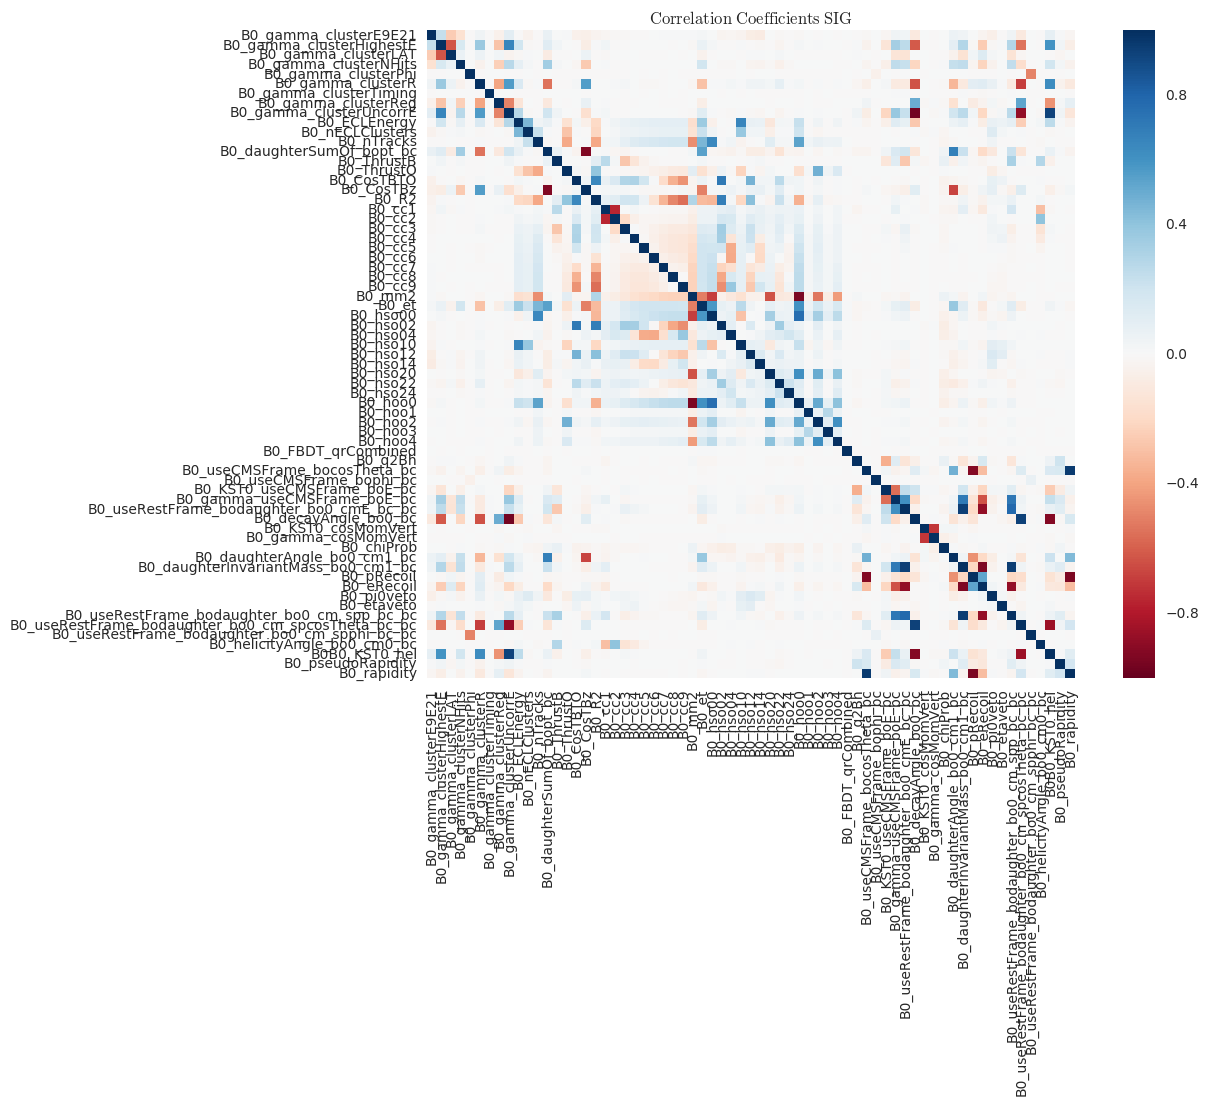

In [39]:
plot_correlations(df_sig.drop(df_sig.columns[-1],1), 'SIG')

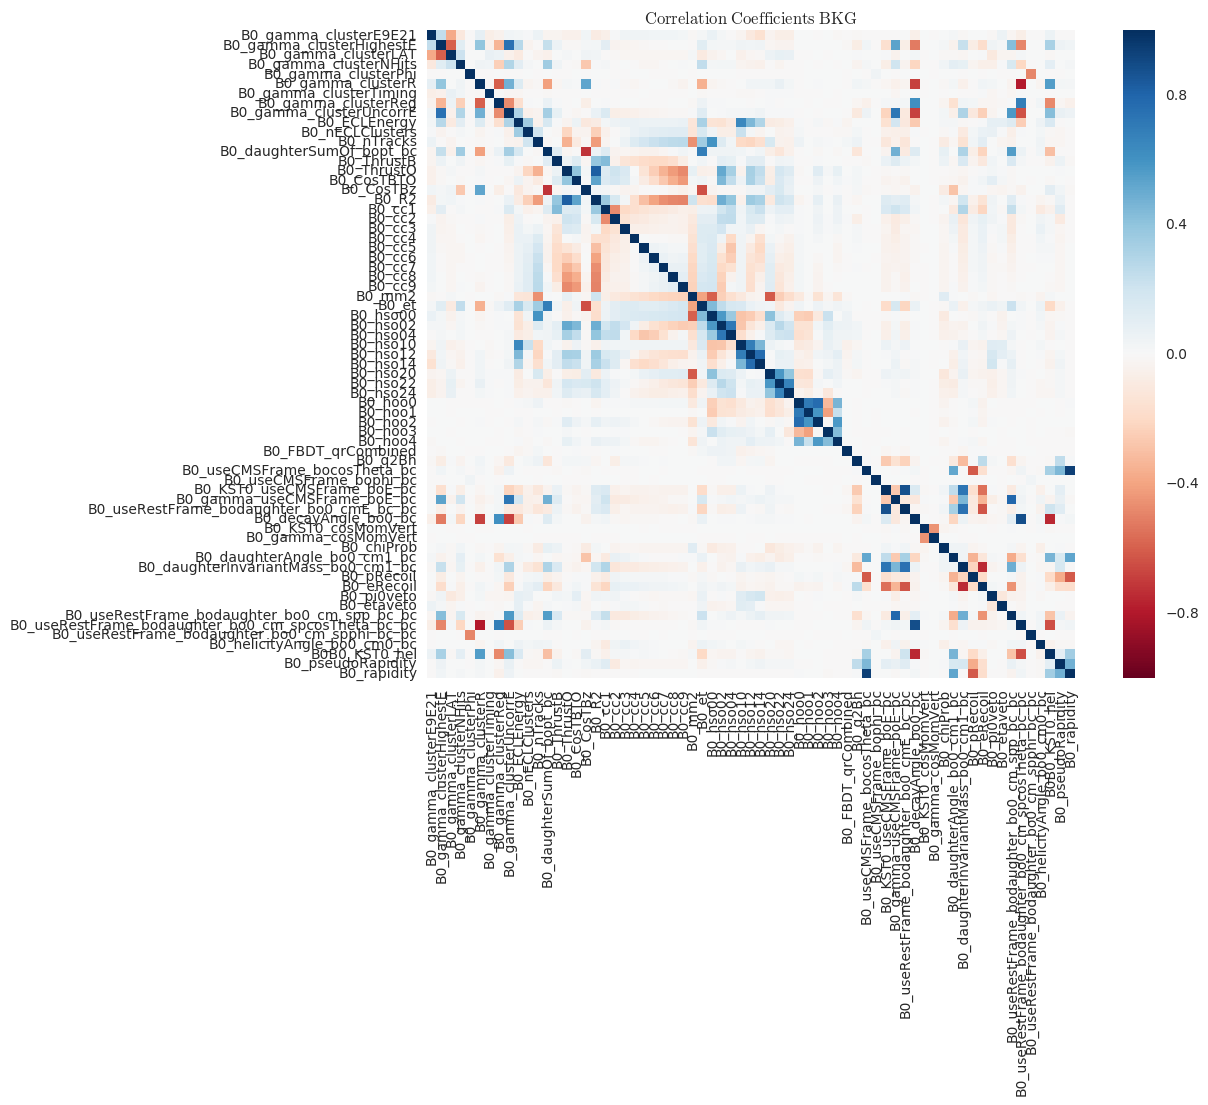

In [40]:
plot_correlations(df_bkg.drop(df_sig.columns[-1],1), 'BKG')

In [95]:
frames = [df_sig,df_bkg]
df_composite = pd.concat(frames, ignore_index = True) #, keys = ['signal', 'background'])

In [96]:
df_composite_norm = df_norm_std(df_composite)
df_composite_norm.describe()

,B0_gamma_clusterE9E21,B0_gamma_clusterHighestE,B0_gamma_clusterLAT,B0_gamma_clusterNHits,B0_gamma_clusterR,B0_gamma_clusterTiming,B0_gamma_clusterReg,B0_gamma_clusterUncorrE,B0_gamma_minC2HDist,B0_gamma_ECLEnergy,...,B0__bopi0veto_bc,B0__boetaveto_bc,B0_useRestFrame_bodaughter_bo0_cm_spp_bc_bc,B0_useRestFrame_bodaughter_bo0_cm_spcosTheta_bc_bc,B0_useRestFrame_bodaughter_bo0_cm_spphi_bc_bc,B0_helicityAngle_bo0_cm0_bc,B0_pseudoRapidity,B0_rapidity,B0B0_rho0_hel,labels
count,5.544280e+05,5.544280e+05,5.544280e+05,5.544280e+05,5.544280e+05,5.544280e+05,5.544280e+05,5.544280e+05,5.544280e+05,5.544280e+05,...,5.544280e+05,5.544280e+05,5.544280e+05,5.544280e+05,5.544280e+05,5.544280e+05,5.544280e+05,5.544280e+05,5.544280e+05,554428.000000
mean,-2.592772e-15,4.587618e-15,-6.249631e-16,7.222460e-14,7.052284e-16,-2.274718e-14,2.120798e-13,1.044737e-15,-2.049880e-15,1.937185e-17,...,5.241046e-13,-1.942180e-13,-1.633484e-15,9.296739e-16,8.698711e-17,4.721414e-17,-3.530087e-15,-8.311114e-17,-4.860144e-17,0.362379
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.481576
min,-4.428253e+00,-2.978045e+00,-2.641643e+00,-5.184700e+00,-1.195822e+00,-7.752600e+01,-2.676783e+00,-2.678960e+00,-1.665936e+00,-4.243022e+00,...,-1.085843e+00,-2.385813e-01,-3.079850e+00,-2.012751e+00,-1.740998e+00,-1.590649e+00,-2.078192e+00,-3.248100e+00,-1.313798e+00,0.000000
25%,1.172299e-02,-7.077603e-01,-7.772073e-01,-4.708433e-01,-7.563051e-01,-2.807146e-01,-3.620930e-03,-6.751861e-01,-7.838166e-01,-6.821683e-01,...,-1.085843e+00,-2.385813e-01,-7.375712e-01,-8.502680e-01,-8.643611e-01,-8.958363e-01,-6.951780e-01,-5.735889e-01,-7.207650e-01,0.000000
50%,3.284905e-01,4.175864e-03,-2.122476e-01,-7.802185e-02,-3.942435e-01,-7.239472e-03,-3.620930e-03,-1.875705e-02,-2.147617e-01,-8.128759e-03,...,9.208970e-01,-2.385813e-01,2.712955e-01,3.324120e-02,9.519875e-04,-4.587100e-03,-1.438109e-01,1.026103e-03,-2.005870e-01,0.000000
75%,5.206278e-01,6.757680e-01,6.399440e-01,7.076210e-01,2.901186e-01,2.350900e-01,-3.620930e-03,6.381400e-01,6.126092e-01,6.681092e-01,...,9.209392e-01,-2.385813e-01,6.313268e-01,8.629260e-01,8.627521e-01,8.939162e-01,4.961328e-01,5.750232e-01,4.569588e-01,1.000000
max,1.142771e+00,4.433847e+00,3.581577e+00,3.064550e+00,2.718197e+00,7.764654e+01,2.669541e+00,4.521801e+00,6.684514e+00,6.844757e+00,...,9.210615e-01,4.191529e+00,2.878559e+00,1.854808e+00,1.738047e+00,1.604230e+00,9.669534e+00,3.300880e+00,1.154726e+01,1.000000


Save to file. Load into classifier in separate notebook.

In [101]:
filename = 'norm_std_B02rho0gamma_continuum.h5'

store = pd.HDFStore(os.path.join('/home/justan/current/jupyter/persistance', mode, 'dataframes', filename))
store['df'] = df_composite_norm
store.close()

### Feature Visualization

In [103]:
def truncate_tails(hist, nsigma = 5):
    # Removes feature outliers above nsigma stddevs away from mean
    hist = hist[hist > np.mean(hist)-nsigma*np.std(hist)]
    hist = hist[hist < np.mean(hist)+nsigma*np.std(hist)]
    return hist

In [104]:
def compare_histograms_overlay(data_sig, data_bkg, nbins = 50, columns=None):
    # Plot continuum suppression variable distributions for signal, background
    sea_green = '#54ff9f'
    steel_blue = '#4e6bbd'
    crimson_tide = '#cc0000'
    yellow = '#ffff00'
    orange = '#ffa500'

    
    for variable in columns:      
        d_sig = truncate_tails(data_sig[variable].values,5)
        d_bkg = truncate_tails(data_bkg[variable].values,5)
        
        sns.distplot(d_sig,color = sea_green, hist=True,label = r'$\mathrm{Signal}$',bins=nbins)       
        sns.distplot(d_bkg,color = steel_blue, hist=True,label = r'$\mathrm{Background}$',kde=False,norm_hist=True,bins=nbins)

#         sns.kdeplot(data_array_bkg, color = steel_blue, label = 'Background',shade =True)
#         sns.kdeplot(d_cfd, color = crimson_tide, label = 'Crossfeed',shade =True)
#         sns.kdeplot(d_gen, color = yellow, label = 'Generic',shade =True)

        plt.title(variable)
        plt.autoscale(enable=True, axis='x', tight=False)
        plt.xlabel(variable)
        plt.ylabel(r'$\mathrm{Normalized \; events/bin}$')
        plt.legend(loc = "best")
        #plt.title(r"$\mathrm{"+variable+"{\; - \; (B \rightarrow K^+ \pi^0) \gamma$")
        #plt.xlim(-1.0,0.98)
        #plt.ylim(0,3.3)
        #plt.xlabel(r'$|(p_B)_{CMS}| \; [GeV/c]$')
        #plt.savefig('graphs/' + mode + variable + '.pdf', bbox_inches='tight',format='pdf', dpi=1000)
        plt.show()
        plt.gcf().clear()

In [113]:
df_sig.columns

Index(['B0_gamma_clusterE9E21', 'B0_gamma_clusterHighestE',
       'B0_gamma_clusterLAT', 'B0_gamma_clusterNHits', 'B0_gamma_clusterR',
       'B0_gamma_clusterTiming', 'B0_gamma_clusterReg',
       'B0_gamma_clusterUncorrE', 'B0_gamma_minC2HDist', 'B0_gamma_ECLEnergy',
       'B0_gamma_nECLClusters', 'B0_nTracks', 'B0_daughterSumOf_bopt_bc',
       'B0_ThrustB', 'B0_ThrustO', 'B0_CosTBTO', 'B0_CosTBz', 'B0_R2',
       'B0_cc1', 'B0_cc2', 'B0_cc3', 'B0_cc4', 'B0_cc5', 'B0_cc6', 'B0_cc7',
       'B0_cc8', 'B0_cc9', 'B0_mm2', 'B0_et', 'B0_hso00', 'B0_hso02',
       'B0_hso04', 'B0_hso10', 'B0_hso12', 'B0_hso14', 'B0_hso20', 'B0_hso22',
       'B0_hso24', 'B0_hoo0', 'B0_hoo1', 'B0_hoo2', 'B0_hoo3', 'B0_hoo4',
       'B0_q2Bh', 'B0_Pcms', 'B0_rho0_Pcms', 'B0_useCMSFrame_bocosTheta_bc',
       'B0_useCMSFrame_bophi_bc', 'B0_rho0_useCMSFrame_bophi_bc',
       'B0_gamma_useCMSFrame_bophi_bc', 'B0_rho0_useCMSFrame_boE_bc',
       'B0_useRestFrame_bodaughter_bo0_cmE_bc_bc', 'B0_gamma_InvM',
   

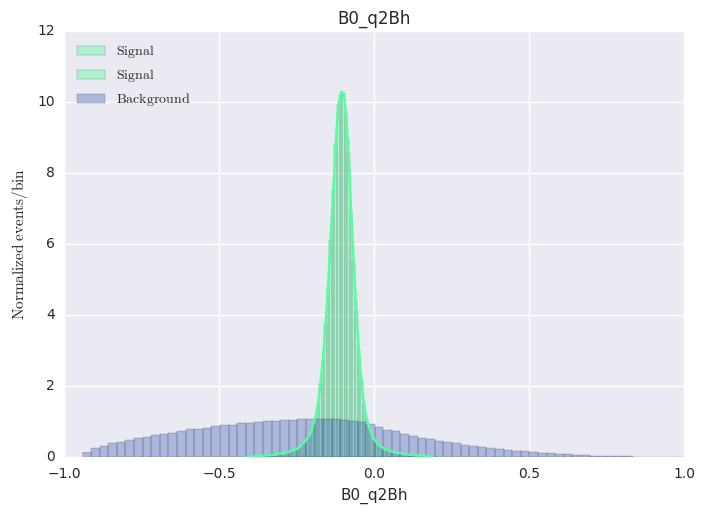

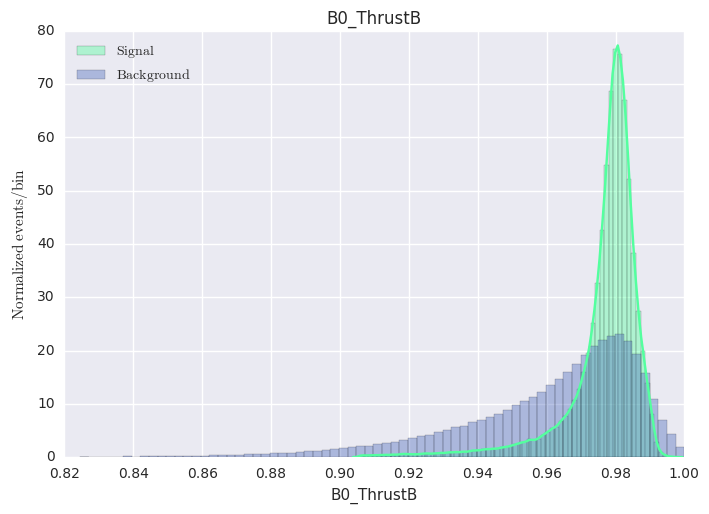

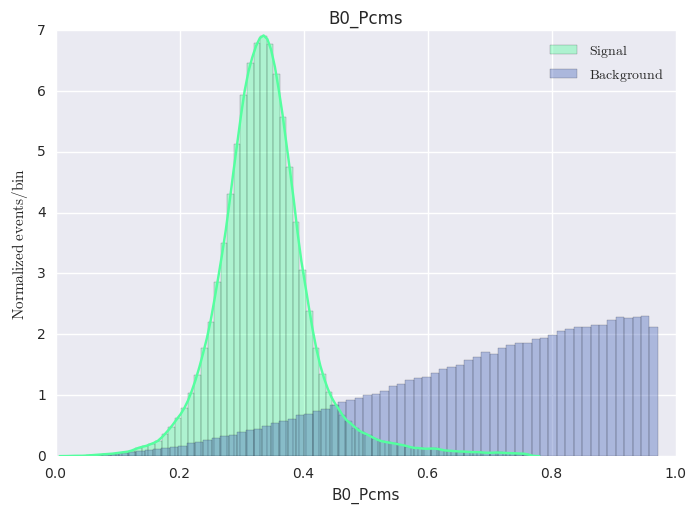

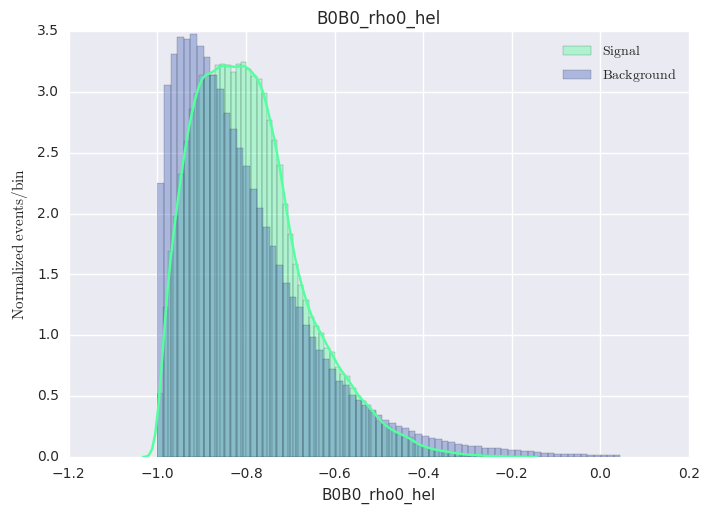

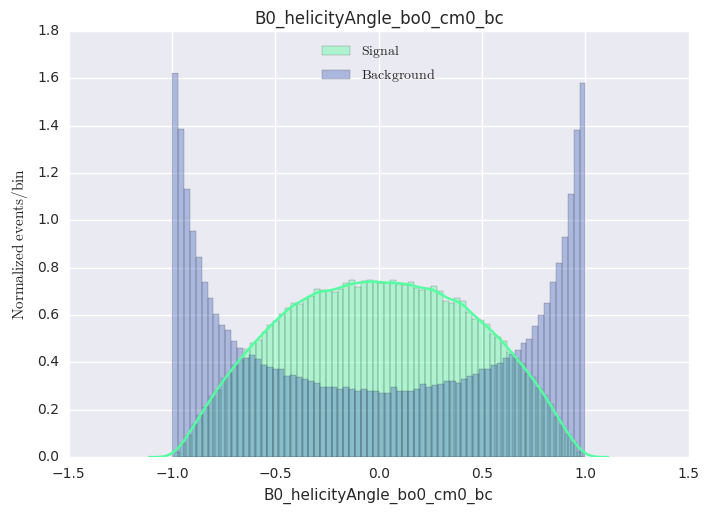

In [115]:
compare_histograms_overlay(df_sig, df_bkg, nbins=70, columns = ['B0_q2Bh', 'B0_ThrustB', 'B0_Pcms', 'B0B0_rho0_hel', 'B0_helicityAngle_bo0_cm0_bc'])